# GENERATE DATA

In [23]:
import numpy as np
N=2000
Fs = 10000
fi=800
fo = 2000

sample = 20000
x = np.arange(sample)
x_in = np.sin(2 * np.pi * fi * x / Fs).reshape(20000,1)
d = np.sin(2 * np.pi * fo * x / Fs).reshape(20000,1)

# PLOT DATA

Text(0.5, 1.0, 'Signals')

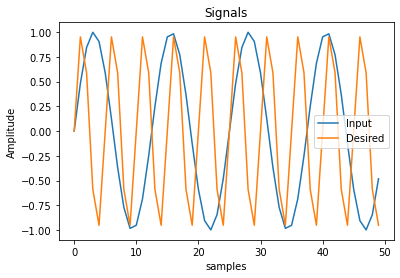

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(x_in[:50],label = "Input")
plt.plot(d[:50],label = "Desired")
plt.ylabel("Amplitude")
plt.xlabel("samples")
plt.legend()
plt.title("Signals")

# IMPORT LIBRARIES

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import linalg
from statsmodels.tsa.stattools import acf,ccf

# IMPLEMENT WIENER FILTER CLASS

In [5]:
fs = 10000
time = np.arange(0, 2, 1/fs)

# generate input signal (2 second sine wave, 1 kHz frequency, 10 kHz sampling)
f_in = 1000
w_in = 2. * np.pi * f_in
sine_1k = np.sin(w_in * time)

# generate desired signal (2 second sine wave, 2 kHz frequency, 10 kHz sampling)
f_des = 2000
w_des = 2. * np.pi * f_des
sine_2k = np.sin(w_des * time)
class Wiener():
    def __init__(self, order, start, length):
        self.order = order
        self.start = start
        self.length = length
        
    def learn(self, input_signal, desired_signal):       
        desired_signal = np.matrix(desired_signal).T
        input_signal = np.matrix(input_signal).T
        A = np.matrix(np.zeros((self.length,self.order)))
        for i in range(self.length):
            A[i,:] = input_signal[i+np.arange(self.order)].T 
        R = A.T*A
        P = A.T*desired_signal[self.start:self.length+self.start]
        w_opt = np.linalg.inv(R)*P
        
        return w_opt

# PREDICT WIENER FILTER OUTPUT

In [6]:
wiener_part1 = Wiener(order=10, start=10, length=10000)
wopt_part1 = wiener_part1.learn(sine_1k, sine_2k)
wopt_part1 = np.asarray(wopt_part1).flatten()

In [7]:
wiener_result_part1 = np.convolve(sine_1k, wopt_part1)

# PLOT WIENER FILTER OUTPUT

Text(0.5, 1.0, 'Signals')

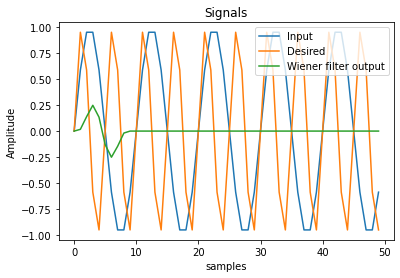

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(x_in[:50],label = "Input")
plt.plot(d[:50],label = "Desired")
plt.plot(wiener_result_part1[:50],label = "Wiener filter output")
plt.ylabel("Amplitude")
plt.xlabel("samples")
plt.legend()
plt.title("Signals")

# IMPLEMENT LMS CLASS

In [9]:
class LMS():
    
    def __init__(self, step_size, order):
        self.step_size = step_size
        self.order = order
        
    def learn(self, u, d):

        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        w = np.random.rand(self.order)
        w_trk = np.zeros((len(d)-self.order, self.order))

        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            w = w + (self.step_size * e[i] * u[i])
            f[i] = y
            w_trk[i] = w 
        return f, w_trk, e 

# GET LMS OUTPUT

In [224]:
lms_part1 = LMS(step_size=0.001, order=10)
outputs_lms_part1, w_trk_lms_part1, error_lms_part1 = lms_part1.learn(x_in, d)

# PLOT LMS OUTPUT

Error is  1627.2221194689107


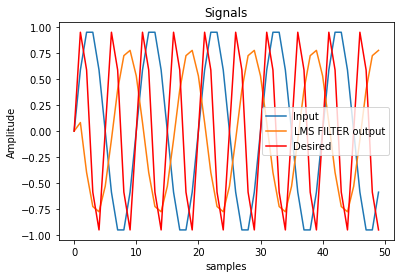

In [226]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(x_in[:50],label = "Input")

plt.plot(outputs_lms_part1[:50],label = "LMS FILTER output")

plt.plot(d[:50],label = "Desired", color='r')
plt.ylabel("Amplitude")
plt.xlabel("samples")
plt.legend()
plt.title("Signals")
MSE1q = np.square(d - outputs_lms_part1).sum()/2000
print('Error is ',MSE1q)

# IMPLEMENT KERNEL

In [4]:
class Kernel:
    def kernel(self, a, b):
        norm = np.linalg.norm(a - b)
        #print(norm)
        term = (norm * norm) / (2 * self.sigma * self.sigma)
        return np.exp(-1 * term)

# IMPLEMENTING KLMS FILTER CLASS

In [5]:

class KLMS(Kernel):
    def __init__(
        self,
        num_params,
        learning_step=0.5,
        sigma=0.1
    ):
        self.inputs = [np.zeros(num_params)]
        self.weights = [0]
        self.learning_step = learning_step
        self.sigma = sigma
        self.error = None
    def predict(self, new_input):
        estimate = 0
        for i in range(0, len(self.weights)):
            addition = self.weights[i] * self.kernel(self.inputs[i], new_input)
            estimate += addition

        return estimate



    def update(self, new_input, expected):
        self.error = expected - self.predict(new_input)
        self.inputs.append(new_input)
        new_weights = self.learning_step * self.error
        self.weights.append(new_weights)

In [24]:
"setting parameter"
order_number = 10
length = 20000
W = np.zeros([1,order_number])
primary_time = np.zeros([length,order_number])

for i in range(length):
    index = i
    for j in range(order_number):
        if index >= 0:
            primary_time[i][j] = x_in[index]
            index -= 1
        else:
            break
            

In [25]:
# weight_KLMS = []
sig = [0.8]
for ii in sig:
    weight_KLMS = []
    klmsFilter = KLMS(10, sigma=1, learning_step=ii)
    Error = np.zeros([1,length])
    predicted = []
    MSE_KLMS = []
    weight = [[0]]
    print("starting .....")
    print("iteration:")
    for i in range(length):
        klmsFilter.update(primary_time[i], d[i])
        weight_KLMS.append(len(klmsFilter.weights))
        Error[0][i] = (klmsFilter.error**2)

    for i in range(length):
        mse = Error[0,0:i+1].sum()/(i+1)
        MSE_KLMS.append(mse)
    print("sig =",ii," ",MSE_KLMS[-1])

starting .....
iteration:
sig = 0.8   0.5448865108366923


# MSE FOR DIFFERENT KERNEL SIZE (KLMS)

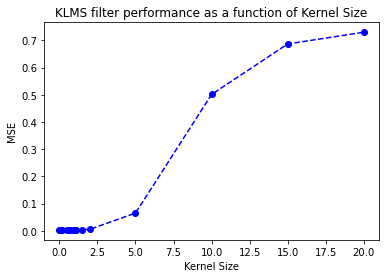

In [8]:
klmssize = [0.001,0.01,0.1,0.2,0.5,0.7,0.9,1,1.1,1.5,2,5,10,15,20]
errklms = [0.004651912418072926,0.004651912418072926,0.004651912409008179,0.004647441343151671,0.00426562265873505,0.003760522098082504,0.003350737264269435,0.0032634196207426687,0.0032557102789092965,0.003812275660304173,0.00548651449705799,0.06519940997900724,0.5012935559981209,0.6869546846025576,0.7299410201526573]
plt.plot(klmssize,errklms, '--bo')
plt.xlabel("Kernel Size")
plt.ylabel("MSE")
plt.title("KLMS filter performance as a function of Kernel Size")
plt.show()

# KLMS PERFORMANCE AS A FUNCTION OF STEP SIZE

In [9]:
#step001= MSE_KLMS #0.39915828042717344

In [10]:
#step01= MSE_KLMS #0.10664948325593554

In [11]:
#step05= MSE_KLMS #0.023150088046678372

In [12]:
#step1= MSE_KLMS #0.01259906355997965

In [13]:
#step2= MSE_KLMS #0.007320584808472586

In [14]:
#step5= MSE_KLMS #0.004111197928708832

In [15]:
#step9= MSE_KLMS #0.0032634196207426687

In [16]:
#step8= MSE_KLMS #0.0031084774413140505

In [17]:
# plt.figure()
# plt.plot(step001,label = "0.001")
# plt.plot(step01,label = "0.01")
# plt.plot(step05,label = "0.05")
# plt.plot(step1,label = "0.1")
# plt.plot(step2,label = "0.2")
# plt.plot(step5,label = "0.5")
# plt.plot(step9,label = "0.8")
# plt.plot(step8,label = "0.9")
# plt.ylabel("Error")
# plt.xlabel("Iterations")
# plt.legend()
# plt.title("KLMS LEARNING CURVE FOR DIFFERENT STEP SIZES")

In [26]:
out=[]
for i in range (20000):
    out.append(klmsFilter.predict(primary_time[i]))

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(x_in[:50],label = "Input")
plt.plot(d[:50],label = "Desired")
plt.plot(out[:50],label = "KLMS output")
plt.ylabel("Amplitude")
plt.xlabel("samples")
plt.legend()
plt.title("KLMS predicted Signal")

In [155]:
print(MSE_KLMS[-1])

0.0032634196207426687


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Learning Curve for KLMS at Step Size of 0.8')

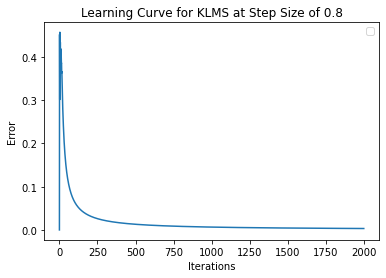

In [156]:
plt.figure()
plt.plot(MSE_KLMS)
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.legend()
plt.title("Learning Curve for KLMS at Step Size of 0.8")

# Define Error Criteria

In [24]:
class Error_Criteria(Kernel):
    def MCC(self, expected, predicted, sigma, learning_step):
        self.sigma = sigma
        self.learning_step = learning_step
        error = expected - predicted
        mcc_weight = error * np.exp((-error**2) / (2 * self.sigma**2))*np.sqrt(2*np.pi)*self.sigma
        return self.learning_step * mcc_weight

# KLMS WITH MCC

In [25]:
class KLMSMCC(Kernel):
    def __init__(
        self,
        num_params,
        learning_step=0.5,
        sigma=0.1
    ):
        self.inputs = [np.zeros(num_params)]
        self.weights = [0]
        self.learning_step = learning_step
        self.sigma = sigma
        self.error = None
        self.error_all = [0]
    def predict(self, new_input):
        estimate = 0
        for i in range(0, len(self.weights)):
            addition = self.weights[i] * self.kernel(self.inputs[i], new_input)
            estimate += addition
        return estimate

    def update(self, new_input, expected):
        predicted = self.predict(new_input)
        self.error = expected - predicted
        self.error_all.append(self.error)
        self.inputs.append(new_input)

        error_criterion = Error_Criteria()
        #MCC
        new_weights = error_criterion.MCC(expected, predicted, self.sigma, self.learning_step) #added
        self.weights.append(new_weights)

In [26]:
%%time
sig = [0.64]
for ii in sig:
    weight_KLMSMCC = []
    klmsFiltermcc = KLMSMCC(10, sigma=1, learning_step=ii)
    Errormcc = np.zeros([1,length])
    predictedmcc = []
    MSE_KLMSMCC = []
    weightmcc = [[0]]
    print("starting .....")
    print("iteration:")
    for i in range(length):
        klmsFiltermcc.update(primary_time[i], d[i])
        weight_KLMSMCC.append(len(klmsFiltermcc.weights))
        Errormcc[0][i] = (klmsFiltermcc.error**2)
        print(i)
    for i in range(length):
        mse = Errormcc[0,0:i+1].sum()/(i+1)
        MSE_KLMSMCC.append(mse)
    print("sig =",ii," ",MSE_KLMSMCC[-1])

starting .....
iteration:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
sig = 0.64   0.003089072940717561
Wall time: 19.9 s


In [27]:
outmcc=[]
for i in range (2000):
    outmcc.append(klmsFiltermcc.predict(primary_time[i]))

Text(0.5, 1.0, 'KLMS-MCC predicted Signal')

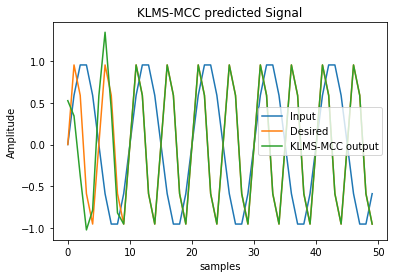

In [28]:
plt.figure()
plt.plot(x_in[:50],label = "Input")
plt.plot(d[:50],label = "Desired")
plt.plot(outmcc[:50],label = "KLMS-MCC output")
plt.ylabel("Amplitude")
plt.xlabel("samples")
plt.legend()
plt.title("KLMS-MCC predicted Signal")

# ADDING NOISE TO DESIRED SIGNAL

In [174]:
noise1 = 0.9*(np.random.normal(0,0.1,2000))
noise2 = 0.1*(np.random.normal(4,0.1,2000))

In [175]:
d_new = []
for i in range(len(d)):
    d_new.append(0.9*np.random.normal(0,0.1) + 0.1*np.random.normal(4,0.1) + d[i])

Text(0.5, 1.0, 'Signals')

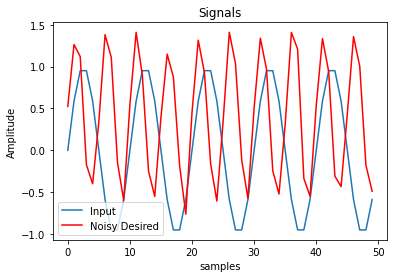

In [176]:
plt.figure()
plt.plot(x_in[:50],label = "Input")
plt.plot(d_new[:50],label = "Noisy Desired", color = 'r')
plt.ylabel("Amplitude")
plt.xlabel("samples")
plt.legend()
plt.title("Signals")

# Implementing KLMS with Noisy desired signal

In [209]:
sig = [0.8]
for ii in sig:
    weight_KLMS = []
    klmsFilter2 = KLMS(10, sigma=1, learning_step=ii)
    Error = np.zeros([1,length])
    predicted = []
    MSE_KLMS = []
    weight = [[0]]
    print("starting .....")
    print("iteration:")
    for i in range(length):
        klmsFilter2.update(primary_time[i], d_new[i])
        weight_KLMS.append(len(klmsFilter2.weights))
        Error[0][i] = (klmsFilter2.error**2)

    for i in range(length):
        mse = Error[0,0:i+1].sum()/(i+1)
        MSE_KLMS.append(mse)
    print("sig =",ii," ",MSE_KLMS[-1])

starting .....
iteration:
sig = 0.8   0.015505507642282756


In [210]:
outnoisy=[]
for i in range (2000):
    outnoisy.append(klmsFilter2.predict(primary_time[i]))

Text(0.5, 1.0, 'KLMS predicted Signal')

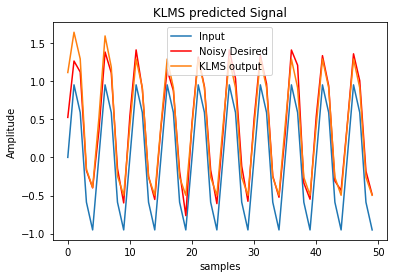

In [211]:
plt.figure()
plt.plot(x_in[:50],label = "Input")
plt.plot(d_new[:50],label = "Noisy Desired", color = 'r')
plt.plot(outnoisy[:50],label = "KLMS output")
plt.ylabel("Amplitude")
plt.xlabel("samples")
plt.legend()
plt.title("KLMS predicted Signal")

# KLMS MEE IMPLEMENTATION

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

t = np.arange(0,2,0.0001)
input = np.sin(3000*np.pi*t)

desired = np.sin(4000*np.pi*t)
mix_noise = 0.9*np.random.normal(0,0.1,desired.shape[0]) + 0.1*np.random.normal(4,0.1,desired.shape[0])
desired = desired + mix_noise

In [30]:
length = input.shape[0]
order_number = 10
X_time = np.zeros([length,order_number])
for i in range(length):
    index = i
    for j in range(order_number):
        X_time[i][j] = input[index]
        index -= 1
        if(index<0):
            break
output = np.zeros([1,length])

L = 1000
sigma = [1.5]
sigma_prime = 0.8
lr = 0.8
for sigma in sigma:
    MSE_curve = np.zeros(length)

    inputs = np.zeros([L+length,order_number])
    errors = np.zeros(L+length)
    weights = np.zeros(L+length)

    for i in range(length):
        phi = np.exp(-(((inputs[0:L+i] - X_time[i])**2).sum(1))/(2*sigma*sigma))
        cur_output = np.dot(weights[0:L+i],phi)
        cur_err = desired[i] - cur_output
        errors[L+i] = cur_err
        inputs[L+i] = X_time[i]
        cur_weight = ((np.exp(-(((errors[i+1:L+i+1] - errors[L+i])**2))/(2*sigma_prime*sigma_prime)))*(errors[L+i] - errors[i+1:L+i+1])).sum()
        weights[L+i] = cur_weight * lr / (L * sigma_prime * sigma_prime)
        phi = np.exp(-(((inputs[0:L + i + 1] - X_time[i]) ** 2).sum(1)) / (2 * sigma * sigma))
        output[0][i] = np.dot(weights[0:L+i + 1],phi)
        MSE_curve[i] = errors[0:L+i+1].sum()/(i+1)







    MSE = np.square(desired - output[0]).sum()/length
    print('for sigma ',sigma,'Error is ',MSE)

for sigma  1.5 Error is  1.454646400898468


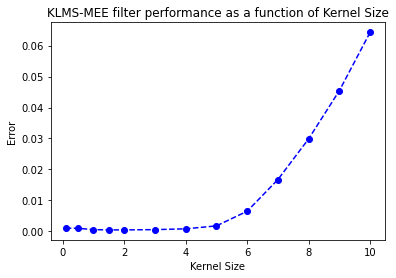

In [165]:
meeker = [0.1,0.5,1,1.5,2,3,4,5,6,7,8,9,10]
meeerr = [0.0010623360657598844,0.000988230960782984,0.0005680702576992581,0.0004755613430866015,0.00048025761636528373,0.0005698322554332532,0.0008264521985108704,0.0017819723978064427,0.006510008560736306,0.016743839170232346,0.029897724382913736,0.04547203348155607,0.06430373127537035]
plt.plot(meeker,meeerr, '--bo')
plt.xlabel("Kernel Size")
plt.ylabel("Error")
plt.title("KLMS-MEE filter performance as a function of Kernel Size")
plt.show()

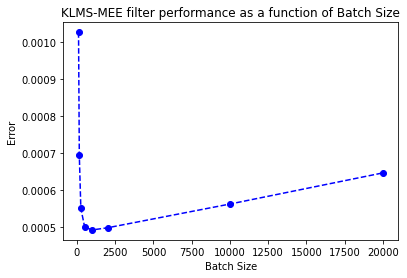

In [166]:
meebatch = L = [100,150,250,500,1000,2000,10000,20000]
batcherr = [0.0010265042062034915,0.0006941516748407953,0.0005506115404961129,0.0004999283654006407,0.0004921682676639397,0.0004979674373390495,0.0005621403809493552,0.0006463245674185008]
plt.plot(meebatch,batcherr, '--bo')
plt.xlabel("Batch Size")
plt.ylabel("Error")
plt.title("KLMS-MEE filter performance as a function of Batch Size")
plt.show()

Text(0.5, 1.0, 'KLMS-MEE predicted Signal')

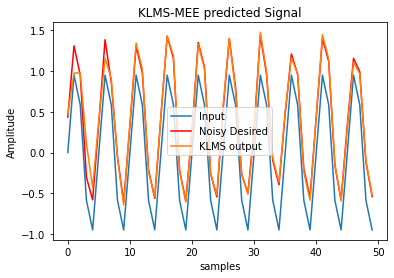

In [171]:
plt.figure()
plt.plot(input[:50],label = "Input")
plt.plot(desired[:50],label = "Noisy Desired", color = 'r')
plt.plot(output[0][:50],label = "KLMS output")
plt.ylabel("Amplitude")
plt.xlabel("samples")
plt.legend()
plt.title("KLMS-MEE predicted Signal")

In [ ]:
"plot frequency response of input"
sr = 10000
w, h = signal.freqz(b=out)
x = w * sr * 1.0 / (2 * np.pi)
y = abs(h) #20 * np.log10(abs(h))
plt.figure(figsize=(10,5))
plt.semilogx(x, y)
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.title('Frequency response')
plt.grid(which='both', linestyle='-', color='grey')
plt.xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], ["20", "50", "100", "200", "500", "1K", "2K", "5K", "10K", "20K"])


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Learning Curve for KLMS-MEE')

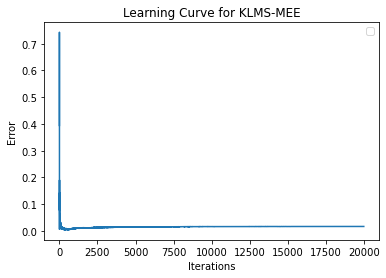

In [162]:
plt.figure()
plt.plot(MSE_curve)
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.legend()
plt.title("Learning Curve for KLMS-MEE")